# Back-testing with Delta Hedging Strategy

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from tqdm import tqdm

from datetime import datetime
from api.definer.data import graph
from api.definer.instruments import *

import torch
import torch.nn as nn
import torch.optim as optim
from api.definer.linear import LinearRegressionModel
from api.definer.core import *

import matplotlib as mpl
mpl.style.use('default')

In [2]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)
torch.random.manual_seed(random_state)

print('Set random seed:{}'.format(random_state))

Set random seed:0


In [3]:
LIVE = False

## Collect Historical Data in USDC-ETH 0.05% Uniswap V3 pool

In [4]:
# USDC-ETH 0.05% Uniswap V3 pool on Ethereum chain
if LIVE:
    address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
    after = '2022-01-01'
    dpd = graph(address, int(datetime.timestamp(datetime.strptime(after, "%Y-%m-%d"))))
    dpd.to_csv('./data/uniswap_v3_usdc_eth.csv')
else:
    dpd = pd.read_csv('./data/uniswap_v3_usdc_eth.csv', index_col=[0])

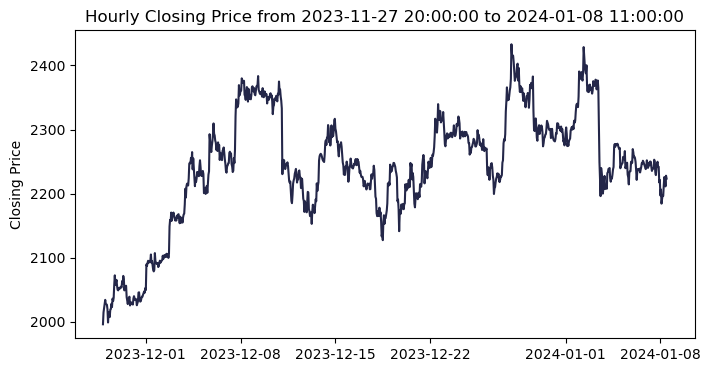

In [5]:
_ = plt.figure(figsize=(8,4))
ax = sns.lineplot(x=pd.to_datetime(dpd.periodStartUnix, unit='s'), y=dpd.close, color='#242749')

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

plt.title('Hourly Closing Price from {} to {}'.format(
    datetime.utcfromtimestamp(dpd.periodStartUnix.min()).strftime('%Y-%m-%d %H:%M:%S'), 
    datetime.utcfromtimestamp(dpd.periodStartUnix.max()).strftime('%Y-%m-%d %H:%M:%S')))
plt.ylabel('Closing Price')
plt.xlabel(None)
# plt.savefig('./img/IL_hedge.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [6]:
n = 1
mini = 1882.32
maxi = 2519.99
target = dpd['close'].iloc[-1] * n
base = 0

In [7]:
decimal0 = dpd.iloc[0]['pool.token0.decimals']
decimal1 = dpd.iloc[0]['pool.token1.decimals']
decimal = decimal1 - decimal0

dpd['fg0'] = ((dpd['feeGrowthGlobal0X128']) / (2 ** 128)) / (10 ** decimal0)
dpd['fg1'] = ((dpd['feeGrowthGlobal1X128']) / (2 ** 128)) / (10 ** decimal1)

dpd['fg0shift'] = dpd['fg0'].shift(-1)
dpd['fg1shift'] = dpd['fg1'].shift(-1)
dpd['fee0token'] = dpd['fg0'] - dpd['fg0shift']
dpd['fee1token'] = dpd['fg1'] - dpd['fg1shift']

In [8]:
SMIN = np.sqrt(mini * 10 ** decimal)
SMAX = np.sqrt(maxi * 10 ** decimal)

initial_price = dpd['close'].iloc[-1]
print("Starting (initial) price:", dpd['close'].iloc[-1])

Starting (initial) price: 1995.8472015960615


In [9]:
if base == 0:  # Token 0 USDC as the base token

    sqrt0 = np.sqrt(dpd['close'].iloc[-1] * 10 ** decimal)
    dpd['price0'] = dpd['close']

else:

    sqrt0 = np.sqrt(1 / dpd['close'].iloc[-1] * 10 ** decimal)
    dpd['price0'] = 1 / dpd['close']


if SMIN < sqrt0 < SMAX:

    deltaL = target / ((sqrt0 - SMIN) + (((1 / sqrt0) - (1 / SMAX)) * (dpd['price0'].iloc[-1] * 10 ** decimal)))
    amount1 = deltaL * (sqrt0 - SMIN)
    amount0 = deltaL * ((1 / sqrt0) - (1 / SMAX)) * 10 ** decimal

elif sqrt0 < SMIN:

    deltaL = target / (((1 / SMIN) - (1 / SMAX)) * (dpd['price0'].iloc[-1]))
    amount1 = 0
    amount0 = deltaL * ((1 / SMIN) - (1 / SMAX))

else:
    
    deltaL = target / (SMAX - SMIN)
    amount1 = deltaL * (SMAX - SMIN)
    amount0 = 0
    
print("Initial amount of Token 0:", round(amount0, 3))
print("Initial amount of Token 1:", round(amount1, 3))
print("Initial net liquidity:", round(deltaL, 6))

Initial amount of Token 0: 0.792
Initial amount of Token 1: 414.618
Initial net liquidity: 0.000322


In [10]:
# print((dpd['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1))
myliquidity = get_liquidity(dpd['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
print("Liquidity position:", myliquidity)

Liquidity position: 321610355724529.9


In [11]:
dpd[['ActiveLiq', 'amount0', 'amount1', 'amount0unb', 'amount1unb']] = 0

if base == 0:
    
    for i, row in dpd.iterrows():
        
        if dpd['high'].iloc[i] > mini and dpd['low'].iloc[i] < maxi:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = (
                    (min(maxi, dpd['high'].iloc[i]) - max(dpd['low'].iloc[i], mini)) / 
                    (dpd['high'].iloc[i] - dpd['low'].iloc[i]) * 100)
        else:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = 0

        amounts = get_amounts(dpd['price0'].iloc[i], mini, maxi, myliquidity, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0')] = amounts[1]
        dpd.iloc[i, dpd.columns.get_loc('amount1')] = amounts[0]

        amountsunb = get_amounts((dpd['price0'].iloc[i]), 1.0001 ** (-887220), 1.0001 ** 887220, 1, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0unb')] = amountsunb[1]
        dpd.iloc[i, dpd.columns.get_loc('amount1unb')] = amountsunb[0]
        
else:
    
    for i, row in dpd.iterrows():

        if (1 / dpd['low'].iloc[i]) > mini and (1 / dpd['high'].iloc[i]) < maxi:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = (min(maxi, 1 / dpd['low'].iloc[i]) - max(
                1 / dpd['high'].iloc[i], mini)) / ((1 / dpd['low'].iloc[i]) - (1 / dpd['high'].iloc[i])) * 100
        else:
            dpd.iloc[i, dpd.columns.get_loc('ActiveLiq')] = 0

        amounts = get_amounts((dpd['price0'].iloc[i] * 10 ** decimal), mini, maxi, myliquidity, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0')] = amounts[0]
        dpd.iloc[i, dpd.columns.get_loc('amount1')] = amounts[1]

        amountsunb = get_amounts((dpd['price0'].iloc[i]), 1.0001 ** (-887220), 1.0001 ** 887220, 1, decimal0, decimal1)
        dpd.iloc[i, dpd.columns.get_loc('amount0unb')] = amountsunb[0]
        dpd.iloc[i, dpd.columns.get_loc('amount1unb')] = amountsunb[1]

In [12]:
dpd['myfee0'] = dpd['fee0token'] * myliquidity * dpd['ActiveLiq'] / 100
dpd['myfee1'] = dpd['fee1token'] * myliquidity * dpd['ActiveLiq'] / 100

if base == 0:
    
    dpd['feeV'] = dpd['myfee0'] + dpd['myfee1'] * dpd['close']
    dpd['amountV'] = dpd['amount0'] + dpd['amount1'] * dpd['close']
    dpd['amountunb'] = dpd['amount0unb'] + dpd['amount1unb'] * dpd['close']
    dpd['fgV'] = dpd['fee0token'] + dpd['fee1token'] * dpd['close']
    
    dpd['feeusd'] = dpd['feeV'] * (
            dpd['pool.totalValueLockedUSD'].iloc[0] / 
            (dpd['pool.totalValueLockedToken1'].iloc[0] * dpd['close'].iloc[0] + (dpd['pool.totalValueLockedToken0'].iloc[0]))
    )

else:

    dpd['feeV'] = dpd['myfee0'] / dpd['close'] + dpd['myfee1']
    dpd['amountV'] = dpd['amount0'] / dpd['close'] + dpd['amount1']
    dpd['feeVbase0'] = dpd['myfee0'] + dpd['myfee1'] * dpd['close']
    dpd['amountunb'] = dpd['amount0unb'] / dpd['close'] + dpd['amount1unb']
    dpd['fgV'] = dpd['fee0token'] / dpd['close'] + dpd['fee1token']
    
    dpd['feeusd'] = dpd['feeV'] * (
            dpd['pool.totalValueLockedUSD'].iloc[0] / 
            (dpd['pool.totalValueLockedToken1'].iloc[0] + (dpd['pool.totalValueLockedToken0'].iloc[0] / dpd['close'].iloc[0]))
    )
    
# dpd['fgV']= (dpd['fg0'] / dpd['close'].iloc[0] + dpd['fg1'])
# print(dpd['fg1'] / dpd['amount1unb'])

dpd['date'] = pd.to_datetime(dpd['periodStartUnix'], unit='s')

In [13]:
data = dpd[['date', 'myfee0', 'myfee1', 'fgV', 'feeV', 'feeusd', 
            'amountV', 'ActiveLiq', 'amountunb', 'amount0', 'amount1', 'close']]
data = data.fillna(0)

dpd_sum = data.resample('D', on='date').sum()
dpd_mean = data.resample('D', on='date').mean()
dpd_first = data.resample('D', on='date').first()
dpd_last = data.resample('D', on='date').last()

## Collecting Options for Delta Hedging Strategy

In [14]:
upper = 5
sample = 100

In [15]:
if LIVE:
    currency = 'ETH'
    options = retrieve_deribit_options(currency=currency)
    print('Total of {} instruments for {} available on Deribit'.format(len(options), currency))
    df_options = pd.DataFrame(options)
    df_options[['currency', 'expire_date', 'strike_price', 'option_type']] = (
        df_options.instrument_name.str.split('-', expand=True))
    df_options = df_options.drop_duplicates()
    df_options.to_csv('./data/deribit_options.csv')
else:
    df_options = pd.read_csv('./data/deribit_options.csv', index_col=[0])
df_options

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,ask_price,bid_price,instrument_name,last,low,high,currency,expire_date,strike_price,option_type
0,0.00070,2222.19,2.41,ETH,1704712781414,ETH,0.0,1.0,ETH-26JAN24,2241.650000,...,0.0010,0.0004,ETH-26JAN24-1200-P,0.0011,0.0011,0.0011,ETH,26JAN24,1200,P
1,NaN,2222.19,0.00,ETH,1704712781414,ETH,0.0,0.0,ETH-12JAN24,2226.350000,...,NaN,NaN,ETH-12JAN24-2550-P,0.0755,NaN,NaN,ETH,12JAN24,2550,P
2,0.03050,2222.19,1709.73,ETH,1704712781414,ETH,0.0,24.0,ETH-23FEB24,2269.040000,...,0.0310,0.0300,ETH-23FEB24-2800-C,0.0320,0.0320,0.0320,ETH,23FEB24,2800,C
3,NaN,2222.19,0.00,ETH,1704712781415,ETH,0.0,0.0,SYN.ETH-10JAN24,2224.200483,...,NaN,NaN,ETH-10JAN24-1950-C,NaN,NaN,NaN,ETH,10JAN24,1950,C
4,0.19475,2222.19,175271.62,ETH,1704712781415,ETH,0.0,391.0,ETH-29MAR24,2293.970000,...,0.1995,0.1900,ETH-29MAR24-2000-C,0.1995,0.1995,0.2005,ETH,29MAR24,2000,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,NaN,2222.19,0.00,ETH,1704712781429,ETH,0.0,0.0,SYN.ETH-9JAN24,2223.125725,...,NaN,NaN,ETH-9JAN24-2850-P,NaN,NaN,NaN,ETH,9JAN24,2850,P
680,0.04000,2222.19,173.73,ETH,1704712781429,ETH,0.0,2.0,SYN.ETH-11JAN24,2225.275242,...,0.0410,0.0390,ETH-11JAN24-2250-P,0.0390,0.0390,0.0390,ETH,11JAN24,2250,P
681,NaN,2222.19,0.00,ETH,1704712781429,ETH,0.0,0.0,ETH-23FEB24,2269.040000,...,NaN,NaN,ETH-23FEB24-1300-C,NaN,NaN,NaN,ETH,23FEB24,1300,C
682,NaN,2222.19,0.00,ETH,1704712781429,ETH,0.0,0.0,ETH-27DEC24,2458.120000,...,NaN,NaN,ETH-27DEC24-7500-P,NaN,NaN,NaN,ETH,27DEC24,7500,P


In [16]:
p0 = initial_price
x = np.linspace(0, upper, sample)
x_list = []

for i in df_options.index:
    c = float(df_options.iloc[i]['ask_price'] * p0)
    k = float(df_options.iloc[i]['strike_price'])
    if df_options.iloc[i]['option_type'] == 'C':
        yl = (np.maximum(0, x * p0 - k) - c) / p0
        # ys = (c - np.maximum(0, x * p0 - k)) / p0
    else:
        yl = (np.maximum(0, k - x * p0) - c) / p0
        # ys = (c - np.maximum(0, k - x * p0)) / p0
    x_list.append(yl)
    # x_list.append(ys)

In [17]:
mat_X = np.array(x_list)
index_option = list(np.where(~np.isnan(mat_X).any(axis=1))[0])
mat_X = mat_X[~np.isnan(mat_X).any(axis=1)]  # remove options with nan payoff

print('Total of {} valid and unique option candidates'.format(mat_X.shape[0]))

Total of 431 valid and unique option candidates


In [18]:
pu = maxi / initial_price
pl = mini / initial_price

x = np.linspace(0, upper, sample)
y = []  # impermanent loss with concentrated liquidity
for i in x:
    if i < pl:
        y.append((np.sqrt(pl) + i / np.sqrt(pl) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
    elif i > pu:
        y.append((i / np.sqrt(pu) + np.sqrt(pu) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))
    else:
        y.append((2 * np.sqrt(i) - 1 - i) / (1 + i - np.sqrt(pl) - i / np.sqrt(pu)))

In [19]:
X = torch.from_numpy(mat_X.transpose())
Y = torch.from_numpy(-np.array(y))
X = X.float()
Y = Y.float()

# Instantiate the model
input_size = X.shape[1]
model = LinearRegressionModel(input_size)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [20]:
progress = tqdm(range(5000))

for epoch in progress:
    epoch_loss = 0
    optimizer.zero_grad()
    for i in range(int(sample / upper * 2)):
        predictions = model(X[i])

        mse_loss = criterion(predictions, Y[i].unsqueeze(0))
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters()) * 0.001
        loss = mse_loss + l2_reg
        
        epoch_loss += loss.item()
        # # Backward pass and optimization
        # optimizer.zero_grad()
        loss.backward()

    optimizer.step()
    progress.set_postfix_str(round(epoch_loss, 4))

100%|██████████| 5000/5000 [01:19<00:00, 62.64it/s, 0.0422]


In [21]:
w = model.linear.weight.data.numpy()  # weights assigned to each option

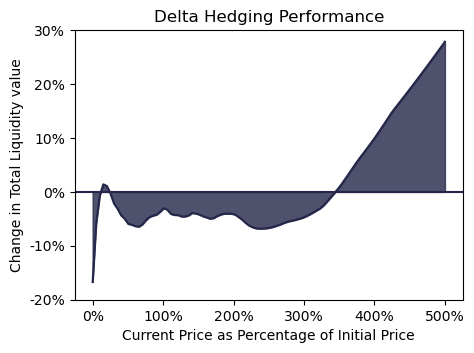

In [30]:
_ = plt.figure(figsize=(5,3.5))
ax = plt.axes()

x = np.linspace(0, upper, sample)
h = np.matmul(mat_X.transpose(), np.array(w).transpose())

plt.plot(x, h.transpose().tolist()[0] + np.array(y), color='#242749')
plt.axhline(color='#242749')

ax.set_ylim(-0.2, 0.3)
# plt.xlim(0, 3)

ax.fill_between(x, 0, h.transpose().tolist()[0] + np.array(y), color='#242749', alpha=0.8)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(vals_y))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(vals_x))
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.title('Delta Hedging Performance')
plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
# plt.savefig('./img/IL_hedge_loss.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [23]:
df_sel = df_options.loc[index_option].reset_index(drop=True)
df_sel['weight'] = pd.Series(w.flatten())
df_sel['today'] = pd.to_datetime('today')
df_sel['v_today'] = pd.to_datetime(datetime.utcfromtimestamp(dpd.periodStartUnix.iloc[-1]).strftime('%Y-%m-%d'))
df_sel['expire_date'] = pd.to_datetime(df_sel['expire_date'])
df_sel['v_expire_date'] = df_sel['v_today'] + (df_sel['expire_date'] - df_sel['today'])

df_sel['v_payoff_date'] = pd.to_datetime(df_sel['v_expire_date'] + pd.DateOffset(1)).dt.date
df_sel

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,high,currency,expire_date,strike_price,option_type,weight,today,v_today,v_expire_date,v_payoff_date
0,0.00070,2222.19,2.41,ETH,1704712781414,ETH,0.0,1.0,ETH-26JAN24,2241.650000,...,0.0011,ETH,2024-01-26,1200,P,0.020626,2024-01-08 19:27:20.781768,2023-11-27,2023-12-14 04:32:39.218232,2023-12-15
1,0.03050,2222.19,1709.73,ETH,1704712781414,ETH,0.0,24.0,ETH-23FEB24,2269.040000,...,0.0320,ETH,2024-02-23,2800,C,0.022271,2024-01-08 19:27:20.781768,2023-11-27,2024-01-11 04:32:39.218232,2024-01-12
2,0.19475,2222.19,175271.62,ETH,1704712781415,ETH,0.0,391.0,ETH-29MAR24,2293.970000,...,0.2005,ETH,2024-03-29,2000,C,-0.036291,2024-01-08 19:27:20.781768,2023-11-27,2024-02-15 04:32:39.218232,2024-02-16
3,0.00040,2222.19,136.63,ETH,1704712781415,ETH,0.0,79.0,SYN.ETH-9JAN24,2223.125725,...,0.0015,ETH,2024-01-09,2450,C,-0.033754,2024-01-08 19:27:20.781768,2023-11-27,2023-11-27 04:32:39.218232,2023-11-28
4,0.08875,2222.19,13793.97,ETH,1704712781415,ETH,0.0,67.0,ETH-28JUN24,2359.870000,...,0.0950,ETH,2024-06-28,1900,P,-0.012008,2024-01-08 19:27:20.781768,2023-11-27,2024-05-16 04:32:39.218232,2024-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0.19900,2222.19,0.00,ETH,1704712781428,ETH,0.0,0.0,ETH-28JUN24,2359.870000,...,NaN,ETH,2024-06-28,2400,P,-0.006353,2024-01-08 19:27:20.781768,2023-11-27,2024-05-16 04:32:39.218232,2024-05-17
427,0.02050,2222.19,183.95,ETH,1704712781428,ETH,0.0,5.0,SYN.ETH-11JAN24,2225.275242,...,0.0200,ETH,2024-01-11,2150,P,-0.027263,2024-01-08 19:27:20.781768,2023-11-27,2023-11-29 04:32:39.218232,2023-11-30
428,0.20650,2222.19,0.00,ETH,1704712781428,ETH,0.0,0.0,ETH-27SEP24,2409.510000,...,NaN,ETH,2024-09-27,2600,C,-0.026198,2024-01-08 19:27:20.781768,2023-11-27,2024-08-15 04:32:39.218232,2024-08-16
429,0.00095,2222.19,0.00,ETH,1704712781429,ETH,0.0,0.0,ETH-28JUN24,2359.870000,...,NaN,ETH,2024-06-28,500,P,0.056374,2024-01-08 19:27:20.781768,2023-11-27,2024-05-16 04:32:39.218232,2024-05-17


In [24]:
data = dpd[['date', 'myfee0', 'myfee1', 'fgV', 'feeV', 'feeusd', 
            'amountV', 'ActiveLiq', 'amountunb', 'amount0', 'amount1', 'close']]
data = data.fillna(0)
dpd_sum = data.resample('D', on='date').sum()
dpd_mean = data.resample('D', on='date').mean()
dpd_first = data.resample('D', on='date').first()
dpd_last = data.resample('D', on='date').last()

final2 = dpd_first[['amountV', 'amount0', 'amount1', 'close']].copy()
final2['feeV'] = dpd_sum['feeV'].copy()
final2[['amountVlast']] = dpd_last[['amountV']]

final2['HODL'] = final2['amount0'].iloc[0] + final2['amount1'].iloc[0] * final2['close']
final2['IL'] = final2['amountVlast'] - final2['HODL']
final2['ActiveLiq'] = dpd_mean['ActiveLiq'].copy()
final2['feecumsum'] = final2['feeV'].cumsum()
final2['PNL'] = final2['feecumsum'] + final2['IL']  # -Bfinal['gas']

final2['HODLnorm'] = final2['HODL'] / final2['amountV'].iloc[0] * 100
final2['ILnorm'] = final2['IL'] / final2['amountV'].iloc[0] * 100
final2['PNLnorm'] = final2['PNL'] / final2['amountV'].iloc[0] * 100
final2['feecumsumnorm'] = final2['feecumsum'] / final2['amountV'].iloc[0] * 100

final2 = final2.reset_index()
final2.date = pd.to_datetime(final2.date)
final2 

,date,amountV,amount0,amount1,close,feeV,amountVlast,HODL,IL,ActiveLiq,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm
0,2023-11-27,1995.847202,414.618074,0.792260,1995.847202,0.138075,2020.023789,1995.847202,24.176588,100.0,0.138075,24.314663,100.000000,1.211345,1.218263,0.006918
1,2023-11-28,2024.748294,551.171005,0.724485,2033.964624,1.543008,2035.320632,2026.046096,9.274536,100.0,1.681082,10.955618,101.513086,0.464692,0.548921,0.084229
2,2023-11-29,2037.293227,614.118984,0.693671,2051.657354,1.274906,2020.728024,2040.063331,-19.335307,100.0,2.955989,-16.379318,102.215407,-0.968777,-0.820670,0.148107
3,2023-11-30,2020.336875,529.601959,0.735105,2027.919857,0.941741,2037.722755,2021.257071,16.465684,100.0,3.897730,20.363413,101.273137,0.824997,1.020289,0.195292
4,2023-12-01,2035.647347,605.717859,0.697768,2049.291627,1.416932,2060.757246,2038.189061,22.568184,100.0,5.314661,27.882846,102.121498,1.130757,1.397043,0.266286
5,2023-12-02,2064.263978,758.788032,0.623851,2092.609735,1.512839,2105.240814,2072.508249,32.732565,100.0,6.827501,39.560065,103.841028,1.640034,1.982119,0.342085
6,2023-12-03,2106.046861,1017.603486,0.502308,2166.883879,1.346550,2118.955984,2131.352653,-12.396669,100.0,8.174051,-4.222618,106.789370,-0.621123,-0.211570,0.409553
7,2023-12-04,2126.865197,1170.768611,0.432339,2211.448850,5.001926,2139.590219,2166.659679,-27.069460,100.0,13.175977,-13.893483,108.558395,-1.356289,-0.696120,0.660170
8,2023-12-05,2143.121110,1308.655471,0.370551,2251.956453,3.803401,2156.898294,2198.752217,-41.853923,100.0,16.979378,-24.874544,110.166360,-2.097050,-1.246315,0.850735
9,2023-12-06,2161.971334,1502.269071,0.285653,2309.455661,2.801998,2135.664564,2244.306517,-108.641953,100.0,19.781377,-88.860576,112.448814,-5.443400,-4.452274,0.991127


In [25]:
df_sel.v_payoff_date = pd.to_datetime(df_sel.v_payoff_date)
df_sel = df_sel.merge(final2[['date', 'close']], left_on='v_payoff_date', right_on='date', how='left')
df_sel = df_sel[~df_sel.date.isna()]
df_sel

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,expire_date,strike_price,option_type,weight,today,v_today,v_expire_date,v_payoff_date,date,close
0,0.00070,2222.19,2.41,ETH,1704712781414,ETH,0.0,1.0,ETH-26JAN24,2241.650000,...,2024-01-26,1200,P,0.020626,2024-01-08 19:27:20.781768,2023-11-27,2023-12-14 04:32:39.218232,2023-12-15,2023-12-15,2301.378284
3,0.00040,2222.19,136.63,ETH,1704712781415,ETH,0.0,79.0,SYN.ETH-9JAN24,2223.125725,...,2024-01-09,2450,C,-0.033754,2024-01-08 19:27:20.781768,2023-11-27,2023-11-27 04:32:39.218232,2023-11-28,2023-11-28,2033.964624
5,0.00040,2222.19,0.00,ETH,1704712781415,ETH,0.0,0.0,ETH-12JAN24,2226.350000,...,2024-01-12,3400,C,0.009385,2024-01-08 19:27:20.781768,2023-11-27,2023-11-30 04:32:39.218232,2023-12-01,2023-12-01,2049.291627
9,0.00215,2222.19,25139.34,ETH,1704712781415,ETH,0.0,4692.0,ETH-12JAN24,2226.350000,...,2024-01-12,2700,C,0.010747,2024-01-08 19:27:20.781768,2023-11-27,2023-11-30 04:32:39.218232,2023-12-01,2023-12-01,2049.291627
10,0.00750,2222.19,2065.83,ETH,1704712781415,ETH,0.0,87.0,SYN.ETH-10JAN24,2224.200483,...,2024-01-10,2125,P,-0.006410,2024-01-08 19:27:20.781768,2023-11-27,2023-11-28 04:32:39.218232,2023-11-29,2023-11-29,2051.657354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.03650,2222.19,5082.44,ETH,1704712781428,ETH,0.0,59.0,ETH-19JAN24,2233.510000,...,2024-01-19,2150,P,-0.021864,2024-01-08 19:27:20.781768,2023-11-27,2023-12-07 04:32:39.218232,2023-12-08,2023-12-08,2361.699721
422,NaN,2222.19,0.00,ETH,1704712781428,ETH,0.0,0.0,SYN.ETH-9JAN24,2223.125725,...,2024-01-09,2850,C,0.000459,2024-01-08 19:27:20.781768,2023-11-27,2023-11-27 04:32:39.218232,2023-11-28,2023-11-28,2033.964624
423,0.00040,2222.19,0.00,ETH,1704712781428,ETH,0.0,0.0,ETH-26JAN24,2241.650000,...,2024-01-26,800,P,0.060251,2024-01-08 19:27:20.781768,2023-11-27,2023-12-14 04:32:39.218232,2023-12-15,2023-12-15,2301.378284
427,0.02050,2222.19,183.95,ETH,1704712781428,ETH,0.0,5.0,SYN.ETH-11JAN24,2225.275242,...,2024-01-11,2150,P,-0.027263,2024-01-08 19:27:20.781768,2023-11-27,2023-11-29 04:32:39.218232,2023-11-30,2023-11-30,2027.919857


In [26]:
df_sel['payoff'] = 0
df_sel.loc[df_sel.option_type == 'C', 'payoff'] = df_sel.weight * (
        np.maximum(0, df_sel.close - df_sel.strike_price.astype('Int64')) - df_sel.ask_price * initial_price)
df_sel.loc[df_sel.option_type == 'P', 'payoff'] = df_sel.weight * (
        np.maximum(0, df_sel.strike_price.astype('Int64') - df_sel.close) - df_sel.ask_price * initial_price)
df_sel['payoff'].sum()

35.50028580849578

In [27]:
df_hedge = df_sel.groupby('date')['payoff'].sum().reset_index()
df_hedge.date = pd.to_datetime(df_hedge.date)
df_hedge

,date,payoff
0,2023-11-28,15.238046
1,2023-11-29,-9.705657
2,2023-11-30,-0.490427
3,2023-12-01,10.966528
4,2023-12-08,1.263801
5,2023-12-15,18.227994


In [28]:
final2.date = pd.to_datetime(final2.date)
final2 = final2.merge(df_hedge, on='date', how='left')
final2 = final2.fillna(0)
final2['cumsum_payoff'] = final2['payoff'].cumsum()
final2

,date,amountV,amount0,amount1,close,feeV,amountVlast,HODL,IL,ActiveLiq,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm,payoff,cumsum_payoff
0,2023-11-27,1995.847202,414.618074,0.792260,1995.847202,0.138075,2020.023789,1995.847202,24.176588,100.0,0.138075,24.314663,100.000000,1.211345,1.218263,0.006918,0.000000,0.000000
1,2023-11-28,2024.748294,551.171005,0.724485,2033.964624,1.543008,2035.320632,2026.046096,9.274536,100.0,1.681082,10.955618,101.513086,0.464692,0.548921,0.084229,15.238046,15.238046
2,2023-11-29,2037.293227,614.118984,0.693671,2051.657354,1.274906,2020.728024,2040.063331,-19.335307,100.0,2.955989,-16.379318,102.215407,-0.968777,-0.820670,0.148107,-9.705657,5.532390
3,2023-11-30,2020.336875,529.601959,0.735105,2027.919857,0.941741,2037.722755,2021.257071,16.465684,100.0,3.897730,20.363413,101.273137,0.824997,1.020289,0.195292,-0.490427,5.041962
4,2023-12-01,2035.647347,605.717859,0.697768,2049.291627,1.416932,2060.757246,2038.189061,22.568184,100.0,5.314661,27.882846,102.121498,1.130757,1.397043,0.266286,10.966528,16.008490
5,2023-12-02,2064.263978,758.788032,0.623851,2092.609735,1.512839,2105.240814,2072.508249,32.732565,100.0,6.827501,39.560065,103.841028,1.640034,1.982119,0.342085,0.000000,16.008490
6,2023-12-03,2106.046861,1017.603486,0.502308,2166.883879,1.346550,2118.955984,2131.352653,-12.396669,100.0,8.174051,-4.222618,106.789370,-0.621123,-0.211570,0.409553,0.000000,16.008490
7,2023-12-04,2126.865197,1170.768611,0.432339,2211.448850,5.001926,2139.590219,2166.659679,-27.069460,100.0,13.175977,-13.893483,108.558395,-1.356289,-0.696120,0.660170,0.000000,16.008490
8,2023-12-05,2143.121110,1308.655471,0.370551,2251.956453,3.803401,2156.898294,2198.752217,-41.853923,100.0,16.979378,-24.874544,110.166360,-2.097050,-1.246315,0.850735,0.000000,16.008490
9,2023-12-06,2161.971334,1502.269071,0.285653,2309.455661,2.801998,2135.664564,2244.306517,-108.641953,100.0,19.781377,-88.860576,112.448814,-5.443400,-4.452274,0.991127,0.000000,16.008490


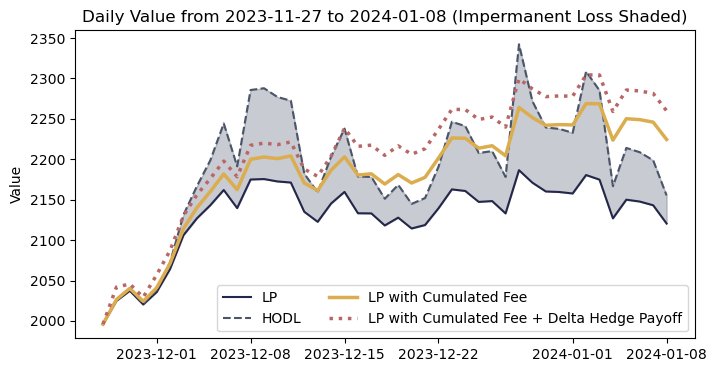

In [29]:
_ = plt.figure(figsize=(8,4))
ax = sns.lineplot(x=final2.date, y=final2.amountV, label='LP', color='#242749')
sns.lineplot(x=final2.date, y=final2.HODL, label='HODL', color='#4B5569', linestyle='--')
sns.lineplot(x=final2.date, y=final2.amountV + final2.feecumsum, label='LP with Cumulated Fee', color='#DBAD4F', linewidth=2.5)
sns.lineplot(x=final2.date, y=final2.amountV + final2.feecumsum + final2.cumsum_payoff, linestyle=':',
             label='LP with Cumulated Fee + Delta Hedge Payoff', color='#B96666', linewidth=2.5)

ax.fill_between(final2.date, list(final2.amountV), list(final2.HODL), color='#4B5569', alpha=0.3)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

plt.title('Daily Value from {} to {} (Impermanent Loss Shaded)'.format(
    datetime.utcfromtimestamp(dpd.periodStartUnix.min()).strftime('%Y-%m-%d'), 
    datetime.utcfromtimestamp(dpd.periodStartUnix.max()).strftime('%Y-%m-%d')))
plt.ylabel('Value')
plt.xlabel(None)
plt.legend(ncol=2)
# plt.savefig('./img/IL_hedge.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()